In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
import ast
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import os
from datetime import datetime

In [2]:
# 方便复现结果
def set_all_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # 如果使用 GPU，也需要固定 CUDA 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU
set_all_seed(42)

In [3]:
# ['education-num', 'sex', 'workclass_index', 'occupation_index', 'relationship_index', 'race_index', 'native-country_index',
# 'age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
# 前7个特征是离散特征，后5个特征是连续特征
df=pd.read_csv("data/exp1/raw.csv")
df

,vectorized_features_1,income,marital-status
0,"[13.0, 1.0, 3.0, 3.0, 1.0, 0.0, 0.0, 39.0, 775...",0,0
1,"[13.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 50.0, 833...",0,1
2,"[9.0, 1.0, 0.0, 8.0, 1.0, 0.0, 0.0, 38.0, 2156...",0,1
3,"[7.0, 1.0, 0.0, 8.0, 0.0, 1.0, 0.0, 53.0, 2347...",0,1
4,"[13.0, 0.0, 0.0, 1.0, 4.0, 1.0, 8.0, 28.0, 338...",0,1
...,...,...,...
45217,"[13.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 33.0, 245...",0,0
45218,"[13.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 39.0, 215...",0,1
45219,"[13.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 38.0, 374...",0,1
45220,"[13.0, 1.0, 0.0, 3.0, 2.0, 2.0, 0.0, 44.0, 838...",0,1


In [4]:
df['vectorized_features_1'] = df['vectorized_features_1'].apply(ast.literal_eval)

In [5]:
x=torch.from_numpy(np.array(df['vectorized_features_1'].values.tolist(),np.float32))
x_d=x[:,:7].long() # 前7维是离散变量，要转为long类型才能送入embedding层
x_c=x[:,7:] # 后5维是连续变量
y1=torch.from_numpy(np.array(df['income'].values.tolist(),np.float32))
y2=torch.from_numpy(np.array(df['marital-status'].values.tolist(),np.float32))
print(x_d)
print(x_d.shape)
print(x_c)
print(x_c.shape)
print(y1)
print(y1.shape)
print(y2)
print(y2.shape)

tensor([[13,  1,  3,  ...,  1,  0,  0],
        [13,  1,  1,  ...,  0,  0,  0],
        [ 9,  1,  0,  ...,  1,  0,  0],
        ...,
        [13,  1,  0,  ...,  0,  0,  0],
        [13,  1,  0,  ...,  2,  2,  0],
        [13,  1,  4,  ...,  0,  0,  0]])
torch.Size([45222, 7])
tensor([[3.9000e+01, 7.7516e+04, 2.1740e+03, 0.0000e+00, 4.0000e+01],
        [5.0000e+01, 8.3311e+04, 0.0000e+00, 0.0000e+00, 1.3000e+01],
        [3.8000e+01, 2.1565e+05, 0.0000e+00, 0.0000e+00, 4.0000e+01],
        ...,
        [3.8000e+01, 3.7498e+05, 0.0000e+00, 0.0000e+00, 5.0000e+01],
        [4.4000e+01, 8.3891e+04, 5.4550e+03, 0.0000e+00, 4.0000e+01],
        [3.5000e+01, 1.8215e+05, 0.0000e+00, 0.0000e+00, 6.0000e+01]])
torch.Size([45222, 5])
tensor([0., 0., 0.,  ..., 0., 0., 1.])
torch.Size([45222])
tensor([0., 1., 1.,  ..., 1., 1., 1.])
torch.Size([45222])


计算两个任务的标签间的pearson相关系数

In [6]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(y1, y2)
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.31953582278616827
P-value: 0.0


In [7]:
class MyDataset(Dataset):
    def __init__(self,x_discrete,x_continuous,y1,y2):
        self.x_d=x_discrete
        self.x_c=x_continuous
        self.y1=y1
        self.y2=y2
    def __len__(self):
        return self.x_d.shape[0]
    def __getitem__(self,idx):
        return (self.x_d[idx],x_c[idx],self.y1[idx],self.y2[idx])

In [8]:
# 训练集30000个样本
train_dataset=MyDataset(x_d[:30000],x_c[:30000],y1[:30000],y2[:30000])
# 验证集7500个样本
val_dataset=MyDataset(x_d[30000:37500],x_c[30000:37500],y1[30000:37500],y2[30000:37500])
# 测试集7500个样本
test_dataset=MyDataset(x_d[37500:45000],x_c[30000:37500],y1[37500:45000],y2[37500:45000])

In [9]:
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, expert_dropout):  # input_dim代表输入维度，output_dim代表输出维度
        super(Expert, self).__init__()

        expert_hidden_layers = [64, 32]
        self.expert_layer = nn.Sequential(
            nn.Linear(input_dim, expert_hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[0], expert_hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[1], output_dim),
            nn.ReLU(),
            nn.Dropout(expert_dropout)
        )

    def forward(self, x):
        out = self.expert_layer(x)
        return out


class Expert_Gate(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)  use_gate：是否使用门控，如果不使用则各个专家取平均
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, expert_dropout, gate_dropout,use_gate=True):  
        super(Expert_Gate, self).__init__()
        self.n_task = n_task
        self.use_gate = use_gate
        self.n_expert = n_expert

        '''专家网络'''
        for i in range(n_expert):
            setattr(self, "expert_layer" + str(i + 1), Expert(feature_dim, expert_dim, expert_dropout))
        self.expert_layers = [getattr(self, "expert_layer" + str(i + 1)) for i in range(n_expert)]  # 为每个expert创建一个DNN

        '''门控网络'''
        for i in range(n_task):
            setattr(self, "gate_layer" + str(i + 1), nn.Sequential(nn.Linear(feature_dim, n_expert), 
                                                                   nn.Dropout(gate_dropout),
                                                                   nn.Softmax(dim=1)))
        self.gate_layers = [getattr(self, "gate_layer" + str(i + 1)) for i in range(n_task)]  # 为每个gate创建一个lr+softmax

    def forward(self, x):
        if self.use_gate:
            # 多个专家网络的输出
            E_net = [expert(x) for expert in self.expert_layers]
            E_net = torch.cat(([e[:, np.newaxis, :] for e in E_net]), dim=1)  # (b,n_expert,expert_dim)

            # 多个门网络的输出
            gate_net = [gate(x) for gate in self.gate_layers]  # n_task个(b,n_expert)
            
            # 记录每个batch内第一个样本的门网络的输出
            for i in range(self.n_task):
                for j in range(self.n_expert):
                    writer.add_scalar(f"task_{i}/expert_{j}_weight", gate_net[i][0][j], tot_iters)

            # towers计算：对应的门网络乘上所有的专家网络
            towers_input = []
            for i in range(self.n_task):
                g = gate_net[i].unsqueeze(2)  # (b,n_expert,1)
                tower_input = torch.matmul(E_net.transpose(1, 2), g)  # (b,d,n_expert)@(b,n_expert,1)-->(b,expert_dim,1)
                towers_input.append(tower_input.squeeze(2))  # (b, expert_dim)
        else:
            E_net = [expert(x) for expert in self.expert_layers]
            towers_input = sum(E_net) / len(E_net)
        return towers_input

In [10]:
class MMoE(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, use_gate=True, tower_dropout=0, expert_dropout=0, gate_dropout=0):
        super(MMoE, self).__init__()

        self.n_task = n_task
        self.use_gate = use_gate
        self.Expert_Gate = Expert_Gate(feature_dim=feature_dim, expert_dim=expert_dim, n_expert=n_expert, n_task=n_task,
                                       expert_dropout=expert_dropout, gate_dropout=gate_dropout, use_gate=use_gate)

        # 对于离散变量做embedding

        # education-num有16种值，但是值域是[1,16]，所以num_embeddings要设置为17，否则会报错
        # sex有2种值
        # workclass_index有7种值
        # occupation_index有14种值
        # relationship_index有6种值
        # race_index有5种值
        # native-country_index有41种值
        # 拼接后总共有4*6+1+5=30维输入
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=17, embedding_dim=4),
            nn.Embedding(num_embeddings=2, embedding_dim=1),
            nn.Embedding(num_embeddings=7, embedding_dim=4),
            nn.Embedding(num_embeddings=14, embedding_dim=4),
            nn.Embedding(num_embeddings=6, embedding_dim=4),
            nn.Embedding(num_embeddings=5, embedding_dim=4),
            nn.Embedding(num_embeddings=41, embedding_dim=4)
        ])

        # 顶层的任务塔
        hidden_layer1 = [64, 32]
        self.towers=nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, hidden_layer1[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer1[0], hidden_layer1[1]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[1], 1))
            for i in range(n_task)
        ])
        
        self.sigmoid=nn.Sigmoid()

    def forward(self, x_d, x_c):
        temp = []
        for i in range(len(self.embeddings)):
            temp.append(self.embeddings[i](x_d[:, i]))
        temp = temp + [x_c]
        x = torch.cat(temp, dim=-1)

        towers_input = self.Expert_Gate(x)

        outputs = []
        if self.use_gate:
            for i in range(self.n_task):
                outputs.append(self.sigmoid(self.towers[i](towers_input[i])))
        else:
            for i in range(self.n_task):
                outputs.append(self.sigmoid(self.towers[i](towers_input)))

        return outputs

In [11]:
# model config
feature_dim=30
expert_dim=32
n_expert=4
n_task=2
use_gate=True
gate_dropout=0.2
tower_dropout=0
expert_dropout=0

In [12]:
mmoe = MMoE(feature_dim=feature_dim,expert_dim=expert_dim,n_expert=n_expert,n_task=n_task,use_gate=use_gate, gate_dropout=gate_dropout, expert_dropout=expert_dropout, tower_dropout=tower_dropout)

nParams = sum([p.nelement() for p in mmoe.parameters()])
print('Number of parameters: %d' % nParams)

Number of parameters: 29540


In [13]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [14]:
if not os.path.exists("model/"):
    os.makedirs("model/") 

In [15]:
def train(mymodel, lr, N_epochs, batch_size):
    global writer
    log_dir = os.path.join("logs/exp1", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    writer = SummaryWriter(log_dir=log_dir)
    global tot_iters
    tot_iters = 0
    mymodel = mymodel.to(device)
    loss_fun = nn.BCELoss()
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
    adam_batch_loss = []
    losses = []
    val_losses = []
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss = []
        mymodel.train()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in train_dataloader:
            tot_iters+=1
            
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)
            
            loss1 = loss_fun(y1_pred, y1_batch)
            loss2 = loss_fun(y2_pred, y2_batch)
            writer.add_scalar(f"loss1", loss1, tot_iters)
            writer.add_scalar(f"loss2", loss2, tot_iters)
            loss = loss1+loss2  # 此处令两个任务的损失值权重均为1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record result
            adam_batch_loss.append(loss.detach().cpu().numpy())
            batch_loss.append(loss.detach().cpu().numpy())

        # val loop
        val_batch_loss = []
        mymodel.eval()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in val_dataloader:
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)

            # record result
            val_batch_loss.append(loss.detach().cpu().numpy())

        # post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))

        # print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        writer.add_scalar(f"train_loss", losses[-1], epoch)
        writer.add_scalar(f"val_loss", val_losses[-1], epoch)

        # save best model
        if (val_losses[-1] < best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(), f'model/best_model_{lr}_{N_epochs}_{batch_size}_{gate_dropout}_{expert_dropout}_{tower_dropout}')
            best_loss = val_losses[-1]
    
    writer.close()

    return losses, val_losses, adam_batch_loss

In [16]:
batch_size=64
N_epochs=100
lr=0.0001

In [17]:
losses, val_losses, adam_batch_loss= train(mymodel=mmoe, lr=lr, N_epochs=N_epochs, batch_size=batch_size)

Epoch=0,train_loss=13.814852714538574,val_loss=2.9478628635406494
current epoch is the best so far. Saving model...
Epoch=1,train_loss=2.9523561000823975,val_loss=1.7820147275924683
current epoch is the best so far. Saving model...
Epoch=2,train_loss=1.8707170486450195,val_loss=1.9779168367385864
Epoch=3,train_loss=1.5850830078125,val_loss=2.8208248615264893
Epoch=4,train_loss=1.5469517707824707,val_loss=2.4132606983184814
Epoch=5,train_loss=1.4636595249176025,val_loss=2.061894178390503
Epoch=6,train_loss=1.4639208316802979,val_loss=1.812761664390564
Epoch=7,train_loss=1.4571659564971924,val_loss=1.7723042964935303
current epoch is the best so far. Saving model...
Epoch=8,train_loss=1.4282562732696533,val_loss=2.261140823364258
Epoch=9,train_loss=1.4005852937698364,val_loss=1.7036762237548828
current epoch is the best so far. Saving model...
Epoch=10,train_loss=1.3364802598953247,val_loss=1.7488949298858643
Epoch=11,train_loss=1.3706917762756348,val_loss=1.6755379438400269
current epoc

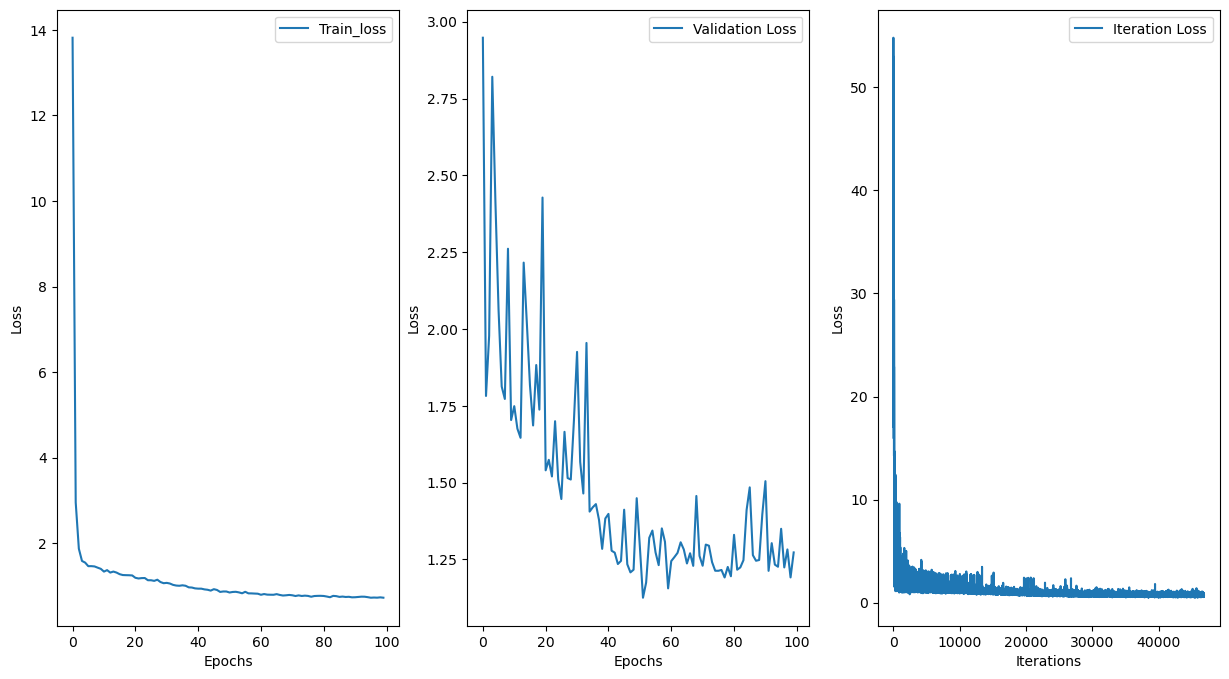

In [18]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 8))

axes[0].plot(range(N_epochs),losses,label="Train_loss")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(range(tot_iters),adam_batch_loss,label="Iteration Loss")
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Loss')
axes[2].legend()

In [19]:
x_d_test, x_c_test, y1_test, y2_test= x_d[37500:45000].to(device),x_c[30000:37500].to(device),y1[37500:45000],y2[37500:45000]

In [20]:
# load best model based on validation
mybestmodel=MMoE(feature_dim=feature_dim,expert_dim=expert_dim,n_expert=n_expert,n_task=n_task,use_gate=use_gate)
mybestmodel.load_state_dict(torch.load(f'model/best_model_{lr}_{N_epochs}_{batch_size}_{gate_dropout}_{expert_dropout}_{tower_dropout}'))

y1_pred,y2_pred = mmoe(x_d_test,x_c_test)

# y1_pred=(y1_pred>0.5).int()
# y2_pred=(y2_pred>0.5).int()

y1_pred=y1_pred.squeeze(1).detach().cpu().numpy()
y2_pred=y2_pred.squeeze(1).detach().cpu().numpy()

In [21]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_true,y_pred):
    # 获取 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # 计算 AUC
    calculated_auc = auc(fpr, tpr)
    print(f"Custom AUC: {calculated_auc}")
    return calculated_auc

In [22]:
auc1=get_auc(y1_test,y1_pred)
auc2=get_auc(y2_test,y2_pred)

Custom AUC: 0.7956789078833247
Custom AUC: 0.8944056283722609


In [23]:
y1_test[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [24]:
y1_pred[:10]

array([0.06491261, 0.04747602, 0.13549362, 0.01819888, 0.02145998,
       0.27292338, 0.06978653, 0.50815946, 0.03124246, 0.51462317],
      dtype=float32)

In [25]:
y2_pred[:10]

array([0.73039603, 0.51658756, 0.92575383, 0.37143195, 0.3931612 ,
       0.996581  , 0.63209426, 0.9999207 , 0.5017044 , 0.99842864],
      dtype=float32)

In [26]:
y2_test[:10]

tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 1.])